In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [30]:
# Load Dataset
file_path = "netflix1.csv"
df = pd.read_csv(file_path)

In [31]:
df.head()

,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,9/25/2021,2020,PG-13,90 min,Documentaries
1,s3,TV Show,Ganglands,Julien Leclercq,France,9/24/2021,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,9/24/2021,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries"
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,9/22/2021,2021,TV-PG,91 min,"Children & Family Movies, Comedies"
4,s8,Movie,Sankofa,Haile Gerima,United States,9/24/2021,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies"


In [32]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in'],
      dtype='object')

In [33]:
df.shape

(8790, 10)

## Exploratory data analysis

In [34]:
# Handle Missing Values
df.fillna("Unknown", inplace=True)

In [35]:
# Convert 'date_added' to datetime format
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

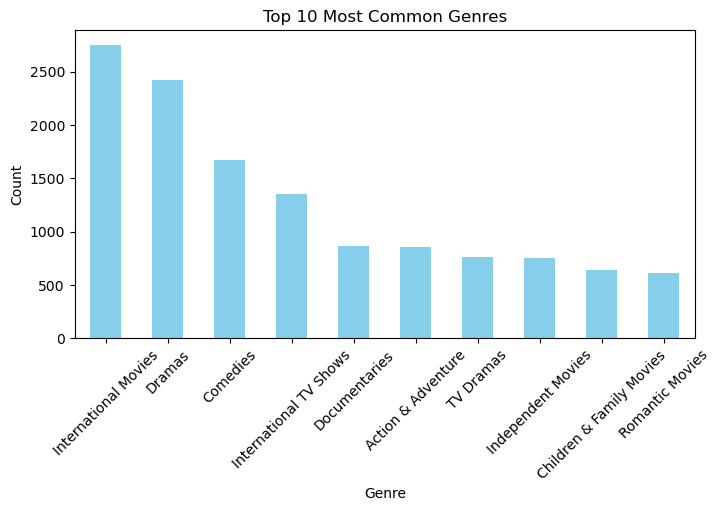

In [36]:
# Top 10 most common genres
genres = df['listed_in'].str.split(', ').explode()
top_genres = genres.value_counts().head(10)
plt.figure(figsize=(8, 4))
top_genres.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Common Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

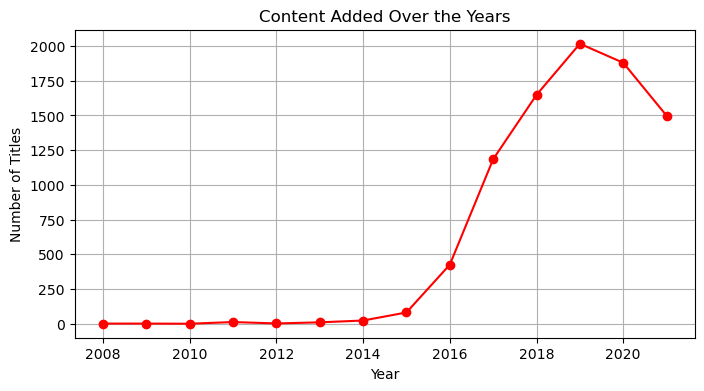

In [37]:
# Trend of content added per year
df['year_added'] = df['date_added'].dt.year.value_counts().sort_index()
df['year_added'].plot(kind='line', marker='o', color='red', figsize=(8, 4))
plt.title('Content Added Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Titles')
plt.grid(True)
plt.show()

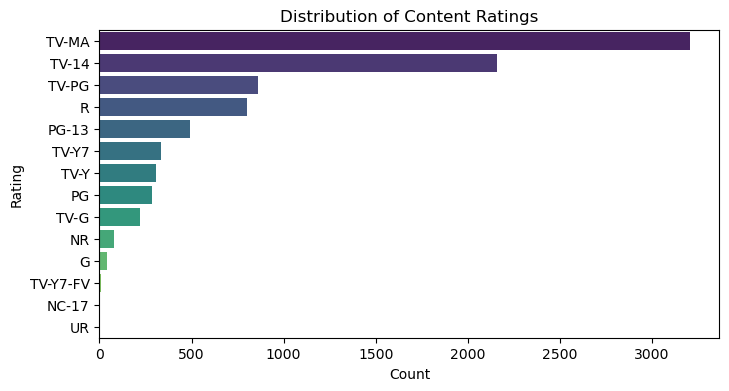

In [38]:
# Distribution of content ratings
plt.figure(figsize=(8, 4))
sns.countplot(y=df['rating'], order=df['rating'].value_counts().index, palette='viridis')
plt.title('Distribution of Content Ratings')
plt.xlabel('Count')
plt.ylabel('Rating')
plt.show()

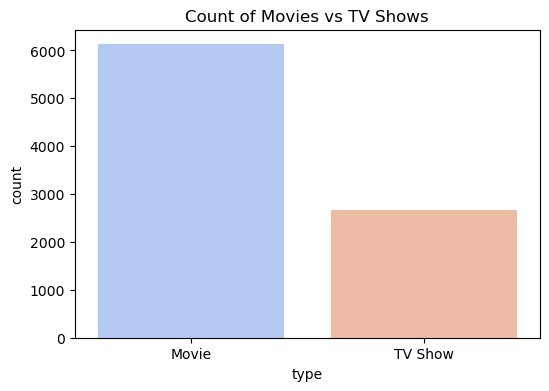

In [39]:
# Count of Movies vs TV Shows
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='type', palette='coolwarm')
plt.title('Count of Movies vs TV Shows')
plt.show()

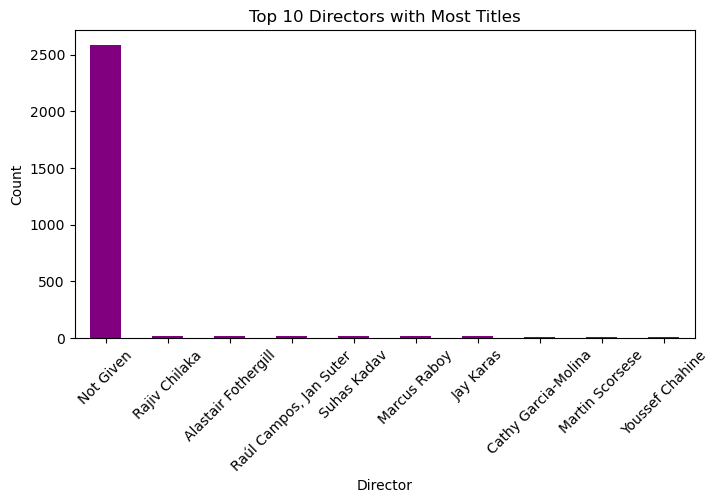

In [40]:
# Top 10 Directors with Most Titles
top_directors = df['director'].value_counts().head(10)
plt.figure(figsize=(8, 4))
top_directors.plot(kind='bar', color='purple')
plt.title('Top 10 Directors with Most Titles')
plt.xlabel('Director')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

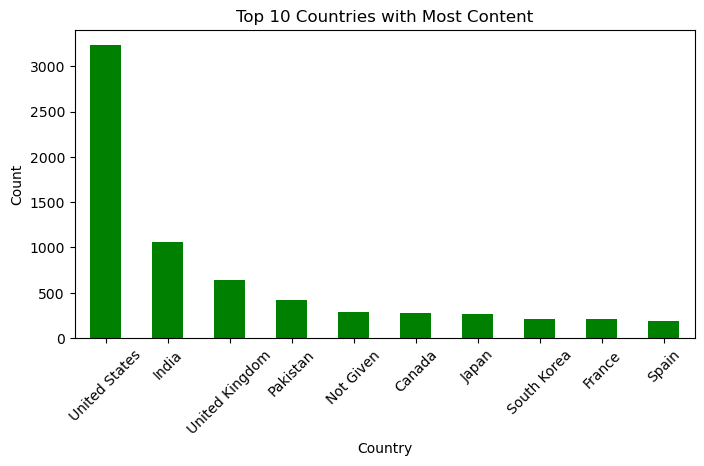

In [41]:
# Top 10 Countries with Most Content
top_countries = df['country'].value_counts().head(10)
plt.figure(figsize=(8, 4))
top_countries.plot(kind='bar', color='green')
plt.title('Top 10 Countries with Most Content')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

C:\Users\neeha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\neeha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


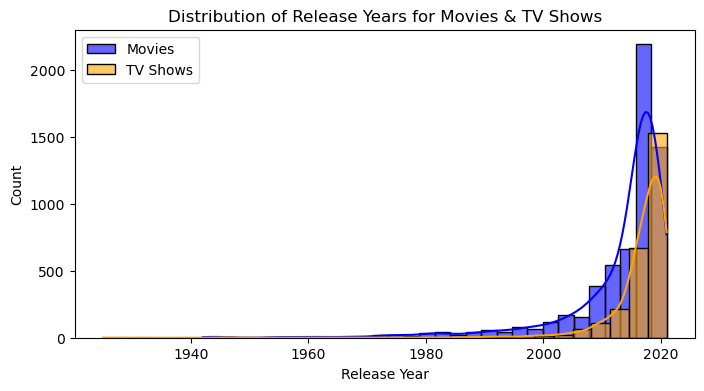

In [42]:
# Movies vs TV Shows Release Year Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[df['type'] == 'Movie']['release_year'], bins=30, kde=True, color='blue', label='Movies', alpha=0.6)
sns.histplot(df[df['type'] == 'TV Show']['release_year'], bins=30, kde=True, color='orange', label='TV Shows', alpha=0.6)
plt.title('Distribution of Release Years for Movies & TV Shows')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.legend()
plt.show()

In [43]:
# Split 'duration' into two separate columns: 'duration_minutes' and 'seasons'
df['duration_minutes'] = df['duration'].apply(lambda x: int(x.split()[0]) if 'min' in x else None)
df['seasons'] = df['duration'].apply(lambda x: int(x.split()[0]) if 'Season' in x else None)

In [44]:
# Content-Based Recommendation System using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['listed_in'] + " " + df['director'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [45]:
def recommend(title, df, cosine_sim):
    if title not in df['title'].values:
        return "Title not found. Please try another."
    idx = df[df['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]  # Top 5 similar movies/shows
    movie_indices = [i[0] for i in sim_scores]
    return df[['title', 'listed_in', 'director']].iloc[movie_indices]

In [46]:
# KNN-Based Recommendation System
knn = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')
knn.fit(tfidf_matrix)

def knn_recommend(title, df, knn, tfidf_matrix):
    if title not in df['title'].values:
        return "Title not found. Please try another."
    idx = df[df['title'] == title].index[0]
    distances, indices = knn.kneighbors(tfidf_matrix[idx], n_neighbors=6)
    recommended_indices = indices.flatten()[1:]
    return df[['title', 'listed_in', 'director']].iloc[recommended_indices]

In [47]:
# Example Recommendation using KNN
print(knn_recommend('Midnight Mass', df, knn, tfidf_matrix))

                        title                           listed_in  \
3677            Before I Wake            Horror Movies, Thrillers   
4174                     Hush            Horror Movies, Thrillers   
3777            Gerald's Game            Horror Movies, Thrillers   
8093                 The Mist  TV Dramas, TV Horror, TV Mysteries   
6619  Brand New Cherry Flavor  TV Dramas, TV Horror, TV Mysteries   

           director  
3677  Mike Flanagan  
4174  Mike Flanagan  
3777  Mike Flanagan  
8093      Not Given  
6619      Not Given  


In [48]:
# Average Duration of Movies
avg_movie_duration = df[df['type'] == 'Movie']['duration_minutes'].mean()
print(f"Average Movie Duration: {avg_movie_duration:.2f} minutes")

Average Movie Duration: 99.58 minutes


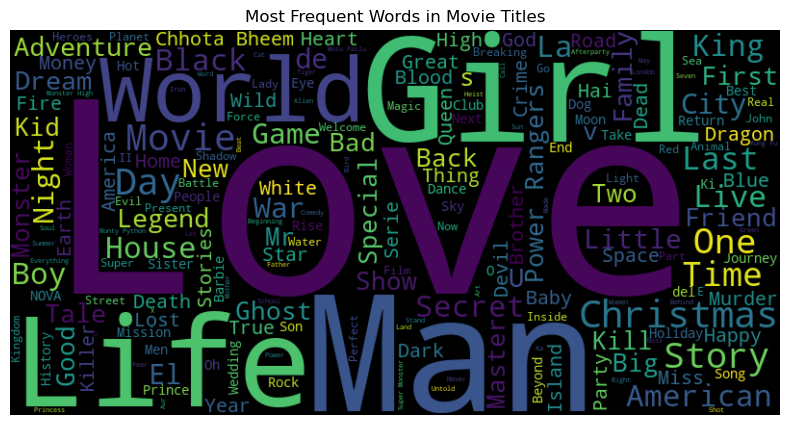

In [49]:
# Word Cloud for Most Common Words in Titles
title_words = ' '.join(df['title'])
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(title_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Movie Titles')
plt.show()

In [50]:
# Display processed dataset sample
df.head()

,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in,year_added,duration_minutes,seasons
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,2021-09-25,2020,PG-13,90 min,Documentaries,NaN,90.0,NaN
1,s3,TV Show,Ganglands,Julien Leclercq,France,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",NaN,NaN,1.0
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,2021-09-24,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries",NaN,NaN,1.0
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,2021-09-22,2021,TV-PG,91 min,"Children & Family Movies, Comedies",NaN,91.0,NaN
4,s8,Movie,Sankofa,Haile Gerima,United States,2021-09-24,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies",NaN,125.0,NaN
